<a href="https://colab.research.google.com/github/sainiakhil/Content-Moderation-System/blob/main/LangGraph_Content_Moderation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydantic
!pip install langchain_core
!pip install langchain_google_genai
!pip install langgraph
!pip install langchain_community

In [2]:
import os
import logging
from typing import TypedDict, List, Literal, Optional, Dict, Annotated

from operator import itemgetter
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from operator import add


In [20]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001", google_api_key= "API_KEY", temperature=0.2)


class ModerationResult(BaseModel):
    """Structured output for a single moderation check."""
    is_violation: bool = Field(description="True if a violation is detected, False otherwise.")
    severity: int = Field(description="Severity of the violation from 1 (low) to 10 (high). 0 if no violation.", ge=0, le=10)
    reasoning: str = Field(description="A brief explanation for the decision.")
    policy_category: str = Field(description="The specific policy category being checked (e.g., 'Toxicity', 'Spam').")

class FinalDecision(BaseModel):
    """The final synthesized decision after all checks are run."""
    final_action: Literal["APPROVE", "REJECT", "REVIEW"] = Field(description="The final recommended action.")
    final_severity: int = Field(description="The overall severity score, consolidating all checks.", ge=0, le=10)
    final_reasoning: str = Field(description="A consolidated, user-facing explanation for the final action.")
    human_review_reason: Optional[str] = Field(description="If action is 'REVIEW', the reason why human oversight is needed.")

# --- The Reducer Function ---
def merge_check_results(left: dict, right: dict) -> dict:
    """Merges the results from parallel checks into a single dictionary."""
    return {**left, **right}

def reduce_and_unique_append(
    left: List[str], right: List[str]
) -> List[str]:
    """
    A reducer with the correct (a, b) -> c signature for LangGraph.
    It combines two lists, ensuring the final list has unique items in order,
    which is essential for de-duplicating the audit trail from parallel branches.
    """

    combined = list(left)
    seen = set(combined)
    for item in right:
        if item not in seen:
            combined.append(item)
            seen.add(item)
    return combined

# --- Graph State Definition ---

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        content_id: A unique identifier for the content being processed.
        content: The user-generated text to moderate.
        user_id: The ID of the user who submitted the content.
        priority: Priority level for processing.
        check_results: A dictionary to store the results of individual checks.
        final_decision: The final synthesized decision.
        audit_trail: A log of actions and decisions taken within the graph.
        appeal_context: Optional context from a user appeal.
    """
    content_id: str
    content: str
    user_id: str
    priority: int

    check_results: Annotated[dict, merge_check_results]
    audit_trail: Annotated[List[str], reduce_and_unique_append]

    final_decision: Optional[FinalDecision]
    appeal_context: Optional[str]



In [21]:
# --- Tool/Chain Creation ---
# Helper function to create reusable LLM chains for different moderation checks.
def create_moderation_chain(system_prompt: str, output_schema: BaseModel):
    """Creates a LangChain Runnable for a specific moderation task."""
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Please analyze the following content:\n\n---\n{content}\n---"),
    ])
    return prompt | llm.with_structured_output(output_schema)

# ---  Node Definitions ---

def triage_content(state: GraphState) -> GraphState:
    """Node 1: Initial, quick triage to filter obviously safe content."""
    state['audit_trail'].append("Triage started.")
    logging.info(f"[{state['content_id']}] Triaging content...")

    if len(state["content"]) < 10:
        decision = FinalDecision(
            final_action="APPROVE",
            final_severity=0,
            final_reasoning="Content is very short and unlikely to be harmful.",
            human_review_reason=None
        )
        state['final_decision'] = decision
        state['audit_trail'].append("Triaged as safe (short content). Bypassing detailed checks.")
        logging.info(f"[{state['content_id']}] Triaged as safe.")
        return state

    state['audit_trail'].append("Triage determined detailed checks are required.")
    logging.info(f"[{state['content_id']}] Triage: Detailed checks needed.")
    return state

def toxicity_check(state: GraphState) -> dict:
    """Parallel Check 1: Checks for toxicity, insults, and threats."""
    logging.info(f"[{state['content_id']}] Running toxicity check...")
    prompt = """You are a toxicity detection expert. Analyze the content for any form of toxic language, including insults, threats, and harassment. Provide a severity score and a clear reason.
    Your policy category is 'Toxicity'."""
    chain = create_moderation_chain(prompt, ModerationResult)
    result = chain.invoke({"content": state["content"]})

    return {
        "check_results": {"toxicity": result},
        "audit_trail": [f"Toxicity check completed: Violation={result.is_violation}, Severity={result.severity}"]
    }

def spam_check(state: GraphState) -> dict:
    """Parallel Check 2: Checks for spam, such as repetitive text or unsolicited ads."""
    logging.info(f"[{state['content_id']}] Running spam check...")
    prompt = """You are a spam detection expert. Analyze the content for spam characteristics like unsolicited advertising, repetitive text, or suspicious links. Provide a severity score and a clear reason.
    Your policy category is 'Spam'."""
    chain = create_moderation_chain(prompt, ModerationResult)
    result = chain.invoke({"content": state["content"]})

    return {
        "check_results": {"spam": result},
        "audit_trail": [f"Spam check completed: Violation={result.is_violation}, Severity={result.severity}"]
    }


def pii_check(state: GraphState) -> dict:
    """Parallel Check 3: Checks for Personally Identifiable Information (PII)."""
    logging.info(f"[{state['content_id']}] Running PII check...")
    prompt = """You are a PII detection expert. Analyze the content for any Personally Identifiable Information like phone numbers, email addresses, or physical addresses. Err on the side of caution. Provide a severity score and a clear reason.
    Your policy category is 'PII'."""
    chain = create_moderation_chain(prompt, ModerationResult)
    result = chain.invoke({"content": state["content"]})

    return {
        "check_results": {"pii": result},
        "audit_trail": [f"PII check completed: Violation={result.is_violation}, Severity={result.severity}"]
    }


def custom_policy_check(state: GraphState) -> dict:
    """Parallel Check 4: Checks for other custom policies like hate speech or self-harm."""
    logging.info(f"[{state['content_id']}] Running custom policy check (Hate Speech/Self-Harm)...")
    prompt = """You are a content policy expert. Analyze the content for violations of our community guidelines, specifically focusing on hate speech and content that promotes self-harm. Provide a severity score and a clear reason.
    Your policy category is 'Custom Policy'."""
    chain = create_moderation_chain(prompt, ModerationResult)
    result = chain.invoke({"content": state["content"]})

    return {
        "check_results": {"custom_policy": result},
        "audit_trail": [f"Custom Policy check completed: Violation={result.is_violation}, Severity={result.severity}"]
    }

def synthesize_results(state: GraphState) -> dict:
    """Node 3: Aggregates all check results into a final decision."""
    logging.info(f"[{state['content_id']}] Synthesizing all check results...")
    state['audit_trail'].append("Synthesizing results.")

    # Synthesize all check results into a single string
    synthesis_input = f"Content to Moderate:\n{state['content']}\n\n"
    if state.get('appeal_context'):
        synthesis_input += f"User Appeal Context:\n{state['appeal_context']}\n\n"

    synthesis_input += "Individual Moderation Check Results:\n"
    for check_name, result in state["check_results"].items():
        synthesis_input += f"- {check_name}: {result.model_dump_json()}\n"

    prompt = """You are a head moderator. Your job is to make a final, decisive judgment on a piece of content based on the reports from your specialized detection agents.

    Rules for your decision:
    1.  **Synthesize**: Do not just repeat the inputs. Combine the reasoning from all reports into a single, clear, and final explanation.
    2.  **Severity**: Calculate a final severity score. This should generally be the *highest* severity reported by any agent, but you can adjust it based on the combination of violations.
    3.  **Action**:
        -   `APPROVE`: If no violations are found.
        -   `REJECT`: For clear, high-severity violations (e.g., severity 8+).
        -   `REVIEW`: For ambiguous cases, multiple low-severity violations, or when an appeal context suggests nuance. Provide a clear `human_review_reason`.
    4.  **Appeal Context**: If a user appeal is present, give it significant weight. It might provide a non-obvious context that could change a REJECT to a REVIEW or an APPROVE.

    Based on the provided information, produce a final decision."""


    chain = create_moderation_chain(prompt, FinalDecision)
    decision = chain.invoke({"content": synthesis_input})

    logging.info(f"[{state['content_id']}] Synthesis complete. Recommended Action: {decision.final_action}")

    # Return only the new information
    return {
        "final_decision": decision,
        "audit_trail": [
            f"Synthesis complete. Final Action: {decision.final_action}, Severity: {decision.final_severity}"
        ]
    }



# --- Conditional Edges ---

def should_run_detailed_checks(state: GraphState) -> Literal["run_parallel_checks", "synthesize_results"]:

    if state.get("final_decision"):

        return "synthesize_results"
    else:
        return "run_parallel_checks"


def route_decision(state: GraphState) -> Literal["auto_approve", "auto_reject", "request_human_review"]:

    final_action = state["final_decision"].final_action
    logging.info(f"[{state['content_id']}] Routing based on final action: {final_action}")

    route = ""
    if final_action == "APPROVE":
        route = "auto_approve"
    elif final_action == "REJECT":
        route = "auto_reject"
    elif final_action == "REVIEW":
        route = "request_human_review"
    else:

        logging.warning(f"[{state['content_id']}] Unexpected final_action '{final_action}'. Defaulting to human review.")
        route = "request_human_review"

    state['audit_trail'].append(f"Routing to '{route}' branch.")
    return route

# --- Final State Nodes ---

def auto_approve(state: GraphState) -> dict:
    """Final State: Content is approved."""
    logging.info(f"[{state['content_id']}] ACTION: Auto-Approved.")
    return {"audit_trail": ["Final state: AUTO_APPROVED"]}

def auto_reject(state: GraphState) -> dict:
    """Final State: Content is rejected."""
    logging.info(f"[{state['content_id']}] ACTION: Auto-Rejected.")
    return {"audit_trail": ["Final state: AUTO_REJECTED"]}

def request_human_review(state: GraphState) -> dict:
    """Final State: Content is queued for human review."""
    logging.info(f"[{state['content_id']}] ACTION: Queued for Human Review.")
    return {"audit_trail": ["Final state: HUMAN_REVIEW_REQUESTED"]}



In [22]:
# --- Graph Assembly ---

memory = MemorySaver()
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("run_parallel_checks", lambda x: x)

workflow.add_node("triage_content", triage_content)
workflow.add_node("toxicity_check", toxicity_check)
workflow.add_node("spam_check", spam_check)
workflow.add_node("pii_check", pii_check)
workflow.add_node("custom_policy_check", custom_policy_check)
workflow.add_node("synthesize_results", synthesize_results)
workflow.add_node("auto_approve", auto_approve)
workflow.add_node("auto_reject", auto_reject)
workflow.add_node("request_human_review", request_human_review)

# Define Edges
workflow.add_edge(START, "triage_content")

workflow.add_conditional_edges(
    "triage_content",
    should_run_detailed_checks,
    {
        "run_parallel_checks": "run_parallel_checks",
        "synthesize_results": "synthesize_results"
    }
)

workflow.add_edge("run_parallel_checks", "toxicity_check")
workflow.add_edge("run_parallel_checks", "spam_check")
workflow.add_edge("run_parallel_checks", "pii_check")
workflow.add_edge("run_parallel_checks", "custom_policy_check")


workflow.add_edge("toxicity_check", "synthesize_results")
workflow.add_edge("spam_check", "synthesize_results")
workflow.add_edge("pii_check", "synthesize_results")
workflow.add_edge("custom_policy_check", "synthesize_results")


workflow.add_conditional_edges(
    "synthesize_results",
    route_decision,
    {
        "auto_approve": "auto_approve",
        "auto_reject": "auto_reject",
        "request_human_review": "request_human_review",
    },
)


workflow.add_edge("auto_approve", END)
workflow.add_edge("auto_reject", END)
workflow.add_edge("request_human_review", END)


app = workflow.compile(checkpointer=memory)

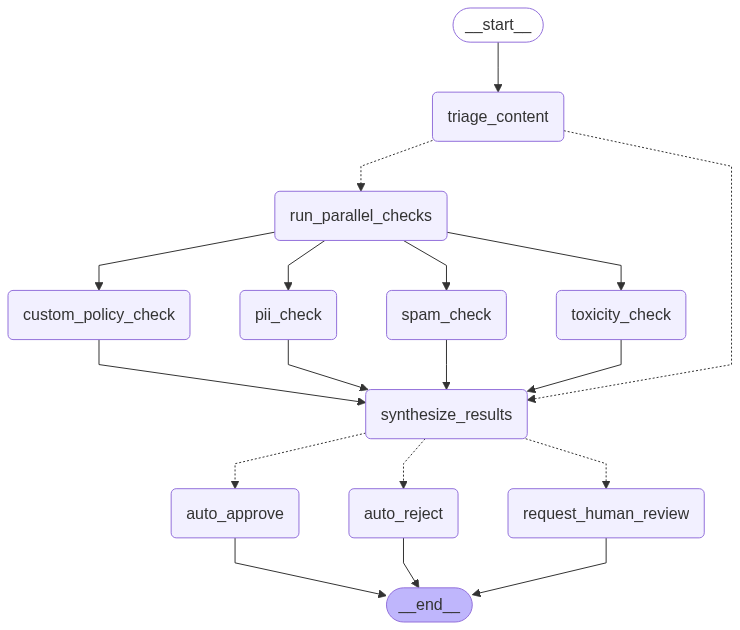

In [23]:
# view
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
# --- Workflow Execution and Simulation ---

def create_initial_state(content_item):
    """Helper to create the initial state for the graph."""
    return {
        "content_id": content_item["id"],
        "content": content_item["content"],
        "user_id": content_item["user_id"],
        "priority": content_item.get("priority", 1),
        "check_results": {},
        "audit_trail": [],
        "appeal_context": content_item.get("appeal_context")
    }

def run_pipeline(content_item):
    """Runs a single item through the moderation pipeline and prints the results."""
    print("\n" + "="*80)
    print(f"Processing Content ID: {content_item['id']} | User: {content_item['user_id']}")
    print(f"Content: '{content_item['content']}'")
    if content_item.get('appeal_context'):
        print(f"Appeal Context: '{content_item['appeal_context']}'")
    print("-"*80)

    initial_state = create_initial_state(content_item)
    thread = {"configurable": {"thread_id": content_item["id"]}}
    final_state = app.invoke(initial_state, config=thread)

    print("\n--- FINAL DECISION ---")
    print(f"Action: {final_state['final_decision'].final_action}")
    print(f"Severity: {final_state['final_decision'].final_severity}")
    print(f"Reasoning: {final_state['final_decision'].final_reasoning}")
    if final_state['final_decision'].human_review_reason:
        print(f"Reason for Human Review: {final_state['final_decision'].human_review_reason}")

    print("\n--- AUDIT TRAIL ---")
    for entry in final_state['audit_trail']:
        print(f"- {entry}")
    print("="*80 + "\n")


if __name__ == "__main__":
    # Simulate a queue of user-generated content
    content_queue = [
        {"id": "post_001", "user_id": "user_123", "content": "Hello everyone, have a wonderful day!"}

    ]

    # Process the queue (batch operation simulation)
    print("--- Starting Content Moderation Batch ---")
    for item in content_queue:
        run_pipeline(item)
    print("--- Content Moderation Batch Finished ---")


--- Starting Content Moderation Batch ---

Processing Content ID: post_001 | User: user_123
Content: 'Hello everyone, have a wonderful day!'
--------------------------------------------------------------------------------

--- FINAL DECISION ---
Action: APPROVE
Severity: 0
Reasoning: The content expresses a positive sentiment and does not violate any of the policies checked, including custom policy, PII, spam, and toxicity.

--- AUDIT TRAIL ---
- Triage started.
- Triage determined detailed checks are required.
- Custom Policy check completed: Violation=False, Severity=0
- PII check completed: Violation=False, Severity=0
- Spam check completed: Violation=False, Severity=0
- Toxicity check completed: Violation=False, Severity=0
- Synthesizing results.
- Synthesis complete. Final Action: APPROVE, Severity: 0
- Final state: AUTO_APPROVED

--- Content Moderation Batch Finished ---


In [25]:
    # --- Appeal Handling Workflow ---
    print("\n\n--- Starting Appeal Handling Simulation ---")
    # A user appeals a decision. We re-run the pipeline with new context.
    appealed_item = {
        "id": "post_002",
        "user_id": "user_456",
        "content": "You are a total idiot and I hate you.",
        "appeal_context": "This was a quote from a movie I was discussing. I wasn't insulting anyone directly."
    }
    run_pipeline(appealed_item)
    print("--- Appeal Handling Simulation Finished ---")



--- Starting Appeal Handling Simulation ---

Processing Content ID: post_002 | User: user_456
Content: 'You are a total idiot and I hate you.'
Appeal Context: 'This was a quote from a movie I was discussing. I wasn't insulting anyone directly.'
--------------------------------------------------------------------------------

--- FINAL DECISION ---
Action: REVIEW
Severity: 8
Reasoning: The content contains insults and expresses hatred, which violates both custom policy and toxicity guidelines. The user claims this was a quote from a movie, which provides context that needs human review to determine if the statement was intended to be harmful or was part of a harmless discussion.
Reason for Human Review: The user claims the statement was a quote from a movie and not a direct personal attack, which requires human verification to determine the context and intent of the statement. 

--- AUDIT TRAIL ---
- Triage started.
- Triage determined detailed checks are required.
- Custom Policy che